Same as initial, but we perform the annotation much earlier

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
adata_shr = sc.read(
    'GSE123818_Root_single_cell_shr_datamatrix.csv.gz',
    cache=True).transpose()
adata_wt = sc.read(
    'GSE123818_Root_single_cell_wt_datamatrix.csv.gz',
    cache=True).transpose()
adata = adata_shr.concatenate(
    adata_wt,
    batch_categories=["shr","wt"])
adata.var_names_make_unique()

In [3]:
gene_bind = pd.read_csv(
    "remapping.complete.tsv", 
    sep="\t", index_col="old")

In [7]:
adata.var = adata.var.join(gene_bind.drop(columns=["easy"]).rename(columns={"new":"other_names"}))

In [9]:
adata.var

other_names
AT1G01010  NAC001 NTL10 T25K16-1 AN1-LOCUS222 AT9943-LOCU...
AT1G01020  ARV1 T25K16-2 AT1G01920 AXX17-AT1G00020 AN1-LO...
AT1G01030                    NGA3 T25K16-3 AT1G01930 NGATHA3
AT1G01040  DCL1 ASU1 SIN1 SUS1 T25K16-4 AT1G01940 AT9943-...
AT1G01050                                      PPA1 T25K16-5
...                                                      ...
ATCG01270                                                NaN
ATCG01280                                                NaN
ATCG01300                                                NaN
ATCG01310                                                NaN
GFP          ATHM3 ATM3 GAT1 THIOREDOXIN-M3 TRX-M3 AT2G15570

[27629 rows x 1 columns]

In [42]:
gene_table = {
    "Columella" : ["AT1G26680", "COBL2", "AT3G55180", "NCED2", "AT5G22550", "ATL63"],
    "QC": ["PAN", "RGF8", "TEL1", "BBM", "DUF9", "AGL42"],
    "NC": ["PLT1", "PLT2"],
    "Endodermis" : ["PER3", "PER9", "PBL15", "TBL30", "AT2G48130", "AT3G22620"],
    "Cortex": ["AED3", "AT1G62510", "AT3G12700", "NPF6-4", "CYP71B34", "IAMT1"],
    "Atrichoblast": ["AT1G31950", "AT1G76620", "GL2", "ANL2", "PMEI4", "AT5G66800"],
    "Trichoblast" : ["EXPA7", "AtGH9C1", "MES15", "ADF8", "COBL9", "TPR14"],
    "Xylem" : ["BHLH144", "MYB83", "SHR", "SCPL35", "MYB46", "COBL4"],
    "QXC": ["ATHB-8"],
    "VC" : ["PIN7", "PIN3"]
}

# Find the gene indexes for each
atg_map = {}
for celltype in gene_table:
    for gene in gene_table[celltype]:
        if gene in atg_map:
            print("duplicate!", gene)
        
        assoc_value = adata.var["other_names"][
            adata.var["other_names"].apply(
                lambda x: gene in str(x).split())]
        ## ) contains("\\s*" + gene + "\\s*")]
        if len(assoc_value) == 0:
            print("[No match:]", gene)
            if gene not in adata.var.index:
                print("  [Not in index either!]")
            else:
                atg_map[gene] = gene
        elif len(assoc_value) == 1:
            #print("Direct match:", gene, "--", assoc_value.values.tolist())
            atg_map[gene]=assoc_value.index.tolist()[0]
        else:
            print("Multiple matches:\n", gene, "--", 
                  assoc_value.values.tolist(),
                  assoc_value.index.tolist())
            atg_map[gene]=assoc_value.index.tolist()

noice = gene_bind[gene_bind["easy"]==1]["new"]
indexes = noice.index.tolist()
values = noice.values.tolist()
for i in range(len(values)):
    ind = indexes[i]
    val = values[i]
    atg_map[val] = ind
            
##gene_bind[gene_bind["easy"]==1]

[No match:] AT5G22550
[No match:] PAN
  [Not in index either!]
[No match:] BBM
  [Not in index either!]
Multiple matches:
 PLT1 -- ['PLT1 AIL3 MOE17-15 AN1-LOCUS13380 AT9943-LOCUS11498 C24-LOCUS13215', 'PLT1 F7H1-14'] ['AT3G20840', 'AT2G16120']
Multiple matches:
 PLT2 -- ['PLT2 AIL4 F11M15-6', 'PLT2 F7H1-15 AT2G20725'] ['AT1G51190', 'AT2G16130']
[No match:] AT3G22620
[No match:] AT1G62510
[No match:] AT3G12700
[No match:] AT1G31950
[No match:] AT1G76620
[No match:] AT5G66800
[No match:] AtGH9C1
  [Not in index either!]
[No match:] SHR
  [Not in index either!]
[No match:] ATHB-8
  [Not in index either!]


... storing 'other_names' as categorical


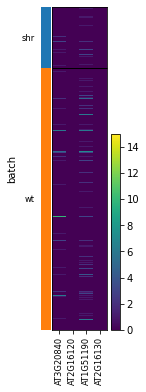

In [29]:
sc.pl.heatmap(adata, ['AT3G20840', 'AT2G16120', 'AT1G51190', 'AT2G16130'], 
              groupby='batch')

So we don't use AT2G16120, AT2G16130

In [43]:
atg_map["PLT1"] = 'AT3G20840'
atg_map["PLT2"] = 'AT1G51190'

In [47]:
inv_atg = {atg_map[x] : x for x in atg_map}

In [82]:
orig = adata.var.index.tolist()
newp = []
for x in orig:
    if x in inv_atg:
        val = inv_atg[x]
        if val.startswith("AXX17-"):
            newp.append(x)
        elif val[0:2] == "AT" and val[3]=="G" and x != val:
            newp.append(x)
        else:
            newp.append(val)
    else:
        newp.append(x)

In [83]:
annots = pd.Series(index=orig, data=newp)
annots.to_csv("gene.annotations.csv", header=["gnames"])

Load in fixed names from script

`join -t, --header -j 1 gene.annotations.csv GSE_something.csv | cut -d, -f 2- | sed -r '1 s|gnames||' > GSE_something.fixednames.csv`

In [84]:
ref1 = pd.read_csv("GSE123818_Root_single_cell_shr_datamatrix.fixednames.csv", index_col=0)
ref2 = pd.read_csv("GSE123818_Root_single_cell_wt_datamatrix.fixednames.csv", index_col=0)

In [85]:
ref1.transpose().to_csv("GSE123818_Root_single_cell_shr_datamatrix.fixednames.transposed.csv")

In [86]:
ref2.transpose().to_csv("GSE123818_Root_single_cell_wt_datamatrix.fixednames.transposed.csv")